<a href="https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/CNN_Candlestick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN Candlestick


* Use historical daily data (open/high/low/close) to generate candlestick charts as the input
* Calculate the future return as the output 1, 0, -1 (Up, Stay, Down)
* Use CNN to train the candlesticks input with the labelled output


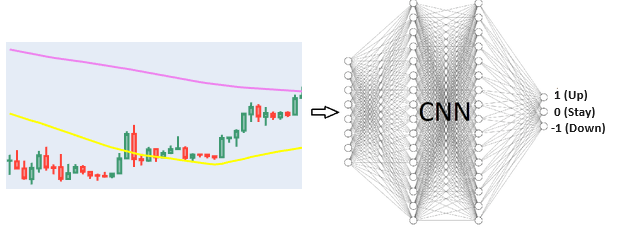

Credit **Jack Zhang** for the ideas and codes

In [ ]:
#@title Execute this block to start importing the libraries and helper functions

!pip install -q kaleido

import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()


my_layout = go.Layout(
    autosize=True,
    width=300,
    height=150,
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis_rangeslider_visible=False,
    showlegend=False,
    yaxis={'visible': False, 'showticklabels': False},
    xaxis={'visible': False, 'showticklabels': False}
)


def getFigure(df, start, end):
  fig = go.Figure(data=[go.Candlestick(
                  x=df.loc[start:end,'Date'],
                  open=df.loc[start:end,'Open'],
                  high=df.loc[start:end,'High'],
                  low=df.loc[start:end,'Low'],
                  close=df.loc[start:end,'Close'])],
                  layout=my_layout)

  fig.add_trace(
      go.Scatter(
          x=df.loc[start:end,'Date'],
          y=df.loc[start:end,'trend'],
          line=dict(color="yellow")
      ))

  fig.add_trace(
      go.Scatter(
          x=df.loc[start:end,'Date'],
          y=df.loc[start:end,'support'],
          line=dict(color="violet")
      ))

  return fig


def assignLabel(number, thresholdPct=5):
  if number < -thresholdPct:
    return -1
  elif number > thresholdPct:
    return 1
  else:
    return 0

In [ ]:
#@title Download historical daily data from Yahoo Finance

ticker = '2800.HK' # @param ["BTC-USD", "ETH-USD", "NVDA", "0700.HK", "2800.HK"] {allow-input: true}
startDate = '2010-01-01' #@param {type:"date"}

stock = yf.Ticker(ticker)

# get stocks daily data OHLCV (Open/High/Low/Close/Volume) from Yahoo Finance
df= stock.history(start=startDate)
df.reset_index(inplace=True)
df['Date'] = df['Date'].dt.date

df

### Apart from the open/high/low/close price to generate the candlestick. Add a yellow **trend line** (short term SMA) and a purple **support line** (long term SMA)


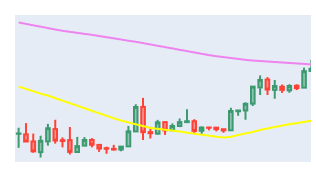


In [ ]:
#@title Set number of the SMA days for the the trend line and support line

trend = 45 #@param {type:"integer"}
support = 125 #@param {type:"integer"}

df['trend'] = df['Close'].rolling(trend).mean()
df['support'] = df['Close'].rolling(support).mean()

# Remove the NaN rows
df.dropna(inplace=True)
df.reset_index(inplace=True)

COLUMNS = ['Date', 'Open', 'High', 'Low', 'Close', 'trend', 'support']
df[COLUMNS]

### Generate labelled data

*   Input: Use open/high/low/close/trend/suport to generate Candlestick Charts
*   Output: [-1, 0, 1] (Down, Stay, Up)

In [ ]:
#@title Generate candlestick charts and output label

timespan = 40 #@param {type:"integer"}
ret_timespan = 10 #@param {type:"integer"}
step = 5  #@param {type:"integer"}
threshold_pct = 5  #@param {type:"integer"}

dataSet = []
for idx in range(0, len(df) - timespan - ret_timespan, step):
  end = idx + timespan
  fig = getFigure(df, idx, end)
  retPct = (df.loc[end + ret_timespan, 'Close'] / df.loc[end,'Close'] -1) * 100
  label = assignLabel(retPct, threshold_pct)
  dataSet.append((fig, label))

  print("Start Date:{}, End Date:{}, Return Date:{}, Return:{:.2f}, Label:{}".format(df.loc[idx, 'Date'], df.loc[end, 'Date'], df.loc[end + ret_timespan, 'Date'], retPct, label))


In [ ]:
for i in range(0, 5):
  dataSet[i][0].show()
  print("label={}".format(dataSet[i][1]))

The following CNN code is generated by **ChatGPT-4** with the following prompt:


> I have a Python list of tuple. In the tuple, the first element is a plotly figure (300x150 pixels, RGB), the second element is the corresponding label (-1, 0, 1). Please write a Python function taking the list as input and use TensorFlow CNN deep learning method to use the first 80% of the samples as training and using the remaining 20% as testing samples.


In [ ]:
#@title Execute this code to use CNN to train and test with the Candlestick dataset

import tensorflow as tf
from tensorflow.keras import layers, models
from plotly.io import to_image
import numpy as np
from PIL import Image
import io

def preprocess_figure(fig, size=(300, 150)):
    # Convert Plotly figure to PNG bytes and then to a PIL Image
    img_bytes = to_image(fig, format='png', width=size[0], height=size[1], scale=1)
    img = Image.open(io.BytesIO(img_bytes))
    return np.array(img)

def encode_labels(labels):
    # Encode labels from -1, 0, 1 to 0, 1, 2 for compatibility with sparse_categorical_crossentropy
    return np.array(labels) + 1

def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_test_model(figures_list):
    # Preprocess figures and labels
    images = [preprocess_figure(fig) for fig, _ in figures_list]
    labels = encode_labels([label for _, label in figures_list])

    # Convert images and labels to numpy arrays
    images = np.array(images)

    # Normalize pixel values to be between 0 and 1
    images = images / 255.0

    # Split data into training and testing sets
    split_index = int(len(images) * 0.8)
    train_images, test_images = images[:split_index], images[split_index:]
    train_labels, test_labels = labels[:split_index], labels[split_index:]

    # Determine the input shape for the CNN
    input_shape = train_images[0].shape

    # Get the number of unique classes
    num_classes = len(np.unique(labels))

    # Build the CNN model
    model = build_cnn_model(input_shape, num_classes)

    # Train the CNN model
    model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f"Test accuracy: {test_acc}")

train_test_model(dataSet)